# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *
import matplotlib.pyplot as plt
import time

## Set to GPU if available

In [2]:
use_gpu = input("Use GPU (y/n) ")
if use_gpu == 'y':
    use_gpu = True
else:
    use_gpu = False
    
device = conf_cuda(use_gpu)

Use GPU (y/n) 
Selected CPU


In [3]:
if use_gpu:
    torch.cuda.empty_cache()

## Set configurations

In [4]:
obs = 'crop_chuncked'
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [5]:
data_path = r"../1-generate/data/"
n_epochs = 10000
hidden_neurons = 200
stop_train = 1e-5

start_match = 45
end_match = 45

start_frame = 1
end_frame = 1017

is_softmax = True

In [6]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/crop_chuncked_m45to45_f1to1017_epoch10000_H200
ATTENTION! folder not created. Training informations will overwrite the existing one


## Load frames and targets

In [7]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [149]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    frames = frames.reshape(end_frame - start_frame + 1, 170, 120)
    frames = frames[:, 30:130, :]
    frames = frames.reshape(end_frame - start_frame + 1, 12000)
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.


In [150]:
data = np.array(frames_arr)/255

In [151]:
match_45 = []
match_46 = []
match_47 = []
match_48 = []
match_49 = []
match_50 = []

In [152]:
frames.shape

(1017, 12000)

In [153]:
indices_45 = [ 0,61,79,105,116,136,141,155,158,165,184,214,225,234,241,251,258,278,280,291,295,298,302,307,314,317,320,328,332,334,353,359,373,376,381,385,389,392,401,413,419,443,446,464,468,486,490,503,505,509,512,524,527,537,551,557,569,575,580,583,587,594,597,603,606,609,617,618,621,630,640,644,661,671,684,692,696,703,717,723,725,734,738,744,753,754,769,772,788,789,798,804,808,822,833,849,853,856,867,873,874,876,882,884,903,905,910,918,922,925,931,942,961,964,983,990,998,1006,1009,1014,1016,1017]

In [154]:
match_45 = []
for i in range(len(indices_45) - 1):
    match_45.append(data[0][indices_45[i]:indices_45[i+1]])

In [14]:
match_45_targets = []
for i in range(len(indices_45) - 1):
    match_45_targets.append(actions_arr[0][indices_45[i]:indices_45[i+1]])

In [15]:
targets = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

In [16]:
data = torch.tensor(data).float()
targets = torch.tensor(targets).float()

In [140]:
match_45[0].shape

(61, 12000)

In [161]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [162]:
train_x = [torch.Tensor([1, 2, 3, 4, 5, 6, 7]),
           torch.Tensor([2, 3, 4, 5, 6, 7]),
           torch.Tensor([3, 4, 5, 6, 7]),
           torch.Tensor([4, 5, 6, 7]),
           torch.Tensor([5, 6, 7]),
           torch.Tensor([6, 7]),
           torch.Tensor([7])]

In [163]:
class MyData(Dataset):

    def __init__(self, train_x):
        self.train_x = train_x

    def __len__(self):
        return len(self.train_x)

    def __getitem__(self, item):
        return self.train_x[item]


train_data = MyData(match_45)
train_dataloader = DataLoader(train_data, batch_size=2)

In [142]:
def collate_fn(train_data):
    train_data.sort(key=lambda data: len(data), reverse=True)
    data_length = [len(data) for data in train_data]
    train_data = rnn_utils.pad_sequence(train_data, batch_first=True, padding_value=0)
    return train_data, data_length

In [155]:
m1 = list(map(lambda x: torch.tensor(x), match_45))
train_data = MyData(m1)
train_dataloader = DataLoader(train_data, batch_size=2, collate_fn=collate_fn)

for data, length in train_dataloader:
    print(data)
    print(length)

tensor([[[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         ...,
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569]],

        [[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       dtype=torch.float64)
[61, 18]
tensor([[[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1

In [156]:
for data, length in train_dataloader:
    data = rnn_utils.pack_padded_sequence(data, length, batch_first=True)
    print(data)

PackedSequence(data=tensor([[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
        ...,
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569]],
       dtype=torch.float64), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)
PackedSequence(data=tensor([[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        ...,
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],

PackedSequence(data=tensor([[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        ...,
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569]],
       dtype=torch.float64), batch_sizes=tensor([2, 1, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)
PackedSequence(data=tensor([[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        ...,
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
        [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569]],
       dtype=torch.float64), batch_sizes=t

In [157]:
net = nn.LSTM(1, 5, batch_first=True)

In [158]:
def collate_fn(train_data):
    train_data.sort(key=lambda data: len(data), reverse=True)
    data_length = [len(data) for data in train_data]
    train_data = rnn_utils.pad_sequence(train_data, batch_first=True, padding_value=0)
    return train_data.unsqueeze(-1), data_length

In [159]:
train_data = MyData(train_x)
train_dataloader = DataLoader(train_data, batch_size=2, collate_fn=collate_fn)

flag = 0
for data, length in train_dataloader:
    data = rnn_utils.pack_padded_sequence(data, length, batch_first=True)
    output, hidden = net(data)
    if flag == 0:
        print(output)
        flag = 1

PackedSequence(data=tensor([[ 0.0120, -0.1200, -0.0909,  0.0076, -0.0830],
        [ 0.0323, -0.0942, -0.1381,  0.0538, -0.0822],
        [ 0.0411, -0.1387, -0.1811,  0.0585, -0.1326],
        [ 0.0476, -0.0931, -0.2149,  0.0906, -0.1210],
        [ 0.0522, -0.1057, -0.2321,  0.0909, -0.1522],
        [ 0.0447, -0.0633, -0.2447,  0.1010, -0.1343],
        [ 0.0467, -0.0658, -0.2518,  0.1002, -0.1551],
        [ 0.0343, -0.0373, -0.2525,  0.0958, -0.1353],
        [ 0.0352, -0.0375, -0.2557,  0.0950, -0.1501],
        [ 0.0237, -0.0212, -0.2507,  0.0829, -0.1304],
        [ 0.0241, -0.0211, -0.2523,  0.0824, -0.1416],
        [ 0.0154, -0.0121, -0.2444,  0.0674, -0.1226],
        [ 0.0156, -0.0121, -0.2453,  0.0670, -0.1315]], grad_fn=<CatBackward>), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 1]), sorted_indices=None, unsorted_indices=None)


In [160]:
train_data = MyData(train_x)
train_dataloader = DataLoader(train_data, batch_size=2, collate_fn=collate_fn)

flag = 0
for data, length in train_dataloader:
    data = rnn_utils.pack_padded_sequence(data, length, batch_first=True)
    output, hidden = net(data)
    if flag == 0:
        output, out_len = rnn_utils.pad_packed_sequence(output, batch_first=True)
        print(output.shape)
        print(output)
        flag = 1

torch.Size([2, 7, 5])
tensor([[[ 0.0120, -0.1200, -0.0909,  0.0076, -0.0830],
         [ 0.0411, -0.1387, -0.1811,  0.0585, -0.1326],
         [ 0.0522, -0.1057, -0.2321,  0.0909, -0.1522],
         [ 0.0467, -0.0658, -0.2518,  0.1002, -0.1551],
         [ 0.0352, -0.0375, -0.2557,  0.0950, -0.1501],
         [ 0.0241, -0.0211, -0.2523,  0.0824, -0.1416],
         [ 0.0156, -0.0121, -0.2453,  0.0670, -0.1315]],

        [[ 0.0323, -0.0942, -0.1381,  0.0538, -0.0822],
         [ 0.0476, -0.0931, -0.2149,  0.0906, -0.1210],
         [ 0.0447, -0.0633, -0.2447,  0.1010, -0.1343],
         [ 0.0343, -0.0373, -0.2525,  0.0958, -0.1353],
         [ 0.0237, -0.0212, -0.2507,  0.0829, -0.1304],
         [ 0.0154, -0.0121, -0.2444,  0.0674, -0.1226],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<TransposeBackward0>)


boraa

In [17]:
import torch
from torch.nn import Embedding, LSTM
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [18]:
# need torch tensors for torch's pad_sequence(); this could be a part of e.g. dataset's __getitem__ instead
DATA_1 = list(map(lambda x: torch.tensor(x), match_45))
match_45_targets = list(map(lambda x: torch.tensor(x), match_45_targets))

In [19]:
seq_len=torch.FloatTensor(list(map(len,match_45)))
print(seq_len)

tensor([61., 18., 26., 11., 20.,  5., 14.,  3.,  7., 19., 30., 11.,  9.,  7.,
        10.,  7., 20.,  2., 11.,  4.,  3.,  4.,  5.,  7.,  3.,  3.,  8.,  4.,
         2., 19.,  6., 14.,  3.,  5.,  4.,  4.,  3.,  9., 12.,  6., 24.,  3.,
        18.,  4., 18.,  4., 13.,  2.,  4.,  3., 12.,  3., 10., 14.,  6., 12.,
         6.,  5.,  3.,  4.,  7.,  3.,  6.,  3.,  3.,  8.,  1.,  3.,  9., 10.,
         4., 17., 10., 13.,  8.,  4.,  7., 14.,  6.,  2.,  9.,  4.,  6.,  9.,
         1., 15.,  3., 16.,  1.,  9.,  6.,  4., 14., 11., 16.,  4.,  3., 11.,
         6.,  1.,  2.,  6.,  2., 19.,  2.,  5.,  8.,  4.,  3.,  6., 11., 19.,
         3., 19.,  7.,  8.,  8.,  3.,  5.,  2.,  1.])


In [20]:
padded = pad_sequence(DATA_1, batch_first=True).float()
print(f' [0] padded: \n{padded}\n')

 [0] padded: 
tensor([[[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         ...,
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569]],

        [[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.7529, 0.1569],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1569, 0.1569, 0.1569,  ..., 0.15

In [21]:
target_padded = pad_sequence(match_45_targets, batch_first=True).float()

In [22]:
packed = pack_padded_sequence(padded, seq_len, batch_first=True, enforce_sorted=False)

In [23]:
target_padded.shape

torch.Size([121, 61, 9])

In [174]:
class Model(nn.Module):
    def __init__(self, device, input_size, output_size, hidden_dim, n_layers, is_softmax):
        super(Model, self).__init__()
        
        self.device = device

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # self.h0 = torch.zeros(self.n_layers, 1, self.hidden_dim).to(self.device)
        # self.c0 = torch.zeros(self.n_layers, 1, self.hidden_dim).to(self.device)

        self.init_hidden()

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)  
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        if is_softmax:
            self.out = nn.Softmax()
        else:
            self.out = nn.Sigmoid()
    
    def forward(self, x):
        
        # batch_size = x.size(0)
        batch_size = 1

        # Initializing hidden state for first input using method defined below
        # hidden = self.init_hidden(batch_size)
        # self.h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)
        # self.c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)

        hidden = self.init_hidden()

        # Passing in the input and hidden state into the model and obtaining outputs
        # out, hidden = self.lstm(x)
        
        print(hidden)
        
        pad_embed_pack_lstm = self.lstm(x, hidden)
        pad_embed_pack_lstm_pad = pad_packed_sequence(pad_embed_pack_lstm[0], batch_first=True)
        
        outs, lens = pad_embed_pack_lstm_pad
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = outs.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        out = self.out(out)
        
        return out
        
    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(1, 12000, 200)
        hidden_b = torch.randn(1, 12000, 200)

        if self.device.type == 'cuda':
            hidden_a = hidden_a.cuda()
            hidden_b = hidden_b.cuda()

        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)

## Create model

In [175]:
model = Model(device=device, input_size=12000, output_size=len(ACTIONS_LIST), hidden_dim=hidden_neurons, n_layers=1, is_softmax=is_softmax)

In [167]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

## Model train

In [168]:
train_loss_arr = np.array([])
train_acc_arr = np.array([])
valid_idx_arr = np.array([])
valid_loss_arr = np.array([])
valid_acc_arr = np.array([])

In [169]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_gpu:
    model.cuda()
    packed = packed.cuda() 
    target_padded = target_padded.cuda()

In [170]:
from torch.nn import Embedding, LSTM

In [171]:
def get_acc_2(output, target):
    soma = 0
    for i in range(len(output)):
        if torch.argmax(target[i]) == torch.argmax(output[i]):
            soma+=1
    return soma/len(output)

In [172]:
match_45

[array([[0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.15686275,
         0.15686275],
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.75294118,
         0.15686275],
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.75294118,
         0.15686275],
        ...,
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.75294118,
         0.15686275],
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.15686275,
         0.15686275],
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.15686275,
         0.15686275]]),
 array([[0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.15686275,
         0.15686275],
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.75294118,
         0.15686275],
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.75294118,
         0.15686275],
        ...,
        [0.15686275, 0.15686275, 0.15686275, ..., 0.15686275, 0.75294118,
         0.15686275],
        [0.1

In [176]:
all_idx = np.arange(len(data))
start_time_processing = time.time()

# Training Run
loss_file = open(newpath + '/' + "loss_file.txt", "w")
first_time = True

best_loss = 1
first_epoch = True

for epoch in range(1, n_epochs + 1):

    model.train()

    optimizer.zero_grad() # Clears existing gradients from previous epoch
    packed.to(device)
    output = model(packed)
    loss = criterion(output, target_padded.view(-1,len(ACTIONS_LIST)).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordinglyw
        
    if epoch%10 == 0:

        train_loss_arr = np.append(train_loss_arr, loss.item())
        #train_acc_arr  = np.append(train_acc_arr, get_acc(output, target_padded.reshape(-1, len(ACTIONS_LIST))))
        train_acc_arr  = np.append(train_acc_arr, get_acc_2(output, target_padded.reshape(-1, len(ACTIONS_LIST))))
        
        loss_file.write("Epoch: {}/{}-------------------------------------------\n".format(epoch, n_epochs))
        loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
            
        print("Epoch: {}/{}-------------------------------------------".format(epoch, n_epochs))
        print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss_arr[-1], train_acc_arr[-1]))
        
        if train_loss_arr[-1] < best_loss:
            state = { 'epoch': epoch + 1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(), 'losslogger': loss.item(), }
            torch.save(state, newpath + '/' + model_name)
            best_loss = loss.item()
        else:
            print("model not saved")
            
loss_file.write("--- %s seconds ---" % (time.time() - start_time_processing))
loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
#np.savez(newpath + '/' + "valid_acc_table", valid_loss_mean_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

(tensor([[[ 1.7863e-02,  1.5741e+00, -7.2367e-01,  ...,  1.2676e-01,
          -3.6110e-01, -1.8572e-01],
         [ 2.4651e-01,  1.1337e-01,  9.6823e-01,  ..., -1.5358e+00,
          -2.0102e-01,  2.8773e+00],
         [-1.7017e+00,  7.7552e-01,  6.9270e-01,  ...,  8.9266e-01,
           5.3903e-01,  1.0806e+00],
         ...,
         [-4.3003e-01, -2.3872e+00, -2.3634e+00,  ...,  4.9728e-01,
          -9.9690e-01,  2.2894e+00],
         [ 1.8838e-01,  9.2274e-01, -2.4678e-01,  ...,  4.0514e-01,
          -4.0308e-01,  1.3399e-01],
         [ 5.8062e-01,  1.6939e-03, -9.7499e-01,  ..., -2.3773e-01,
           1.3762e+00, -1.0072e+00]]]), tensor([[[ 0.1869, -0.1313, -0.0180,  ...,  1.0378,  1.1669, -0.2077],
         [ 0.8098, -1.7685, -1.0316,  ...,  1.3520,  1.7188,  0.1206],
         [-0.5234, -1.4753, -1.5145,  ...,  0.6027, -1.6665, -1.8295],
         ...,
         [-0.1618, -0.4634,  0.9436,  ...,  0.2475, -1.1051,  0.1298],
         [ 0.1992,  2.0468,  0.7737,  ...,  0.8878,  1

C:\Users\alece\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor([[[ 1.8731e+00, -2.1470e+00,  2.2396e+00,  ..., -1.1195e+00,
           1.4165e+00, -4.2570e-02],
         [-6.3323e-02,  5.9145e-01, -1.3754e-01,  ...,  2.3823e-01,
           1.9004e+00, -1.2996e-01],
         [ 6.3832e-01,  9.8093e-01, -9.7987e-01,  ...,  1.0778e+00,
           1.7346e+00, -1.0706e+00],
         ...,
         [ 6.8459e-01, -9.8938e-01, -3.7753e-01,  ..., -1.3731e-03,
           2.1536e+00,  6.1357e-01],
         [ 1.3079e+00, -7.2096e-01, -1.7616e+00,  ..., -3.8216e-01,
           1.1782e+00,  3.4144e-01],
         [ 1.1221e+00,  2.7103e-01, -4.0285e-02,  ..., -7.6166e-02,
           1.1462e+00,  1.3524e-01]]]), tensor([[[-0.2417,  1.2428,  1.1542,  ...,  0.2980,  1.7067, -0.4068],
         [-0.3818, -0.4544,  0.4097,  ..., -0.4971, -0.3681, -1.0214],
         [ 1.0747, -0.1513,  0.5298,  ...,  0.6372,  0.8504,  0.5163],
         ...,
         [ 0.0286, -1.8309, -1.1048,  ..., -0.8941, -1.2654, -0.0039],
         [ 0.6869,  0.3116, -0.7860,  ...,  0.6746, -0

KeyboardInterrupt: 

In [116]:
torch.argmax( torch.tensor([ [0,10,2,3] ] ) )

tensor(1)

In [117]:
get_acc_2( torch.tensor([[0,1,2,3], [0,1,0,0], [0,1,2,3]] ), torch.tensor( [[3,2,1,10], [0,1,0,6], [0,1,2,3]] ))

0.6666666666666666

In [118]:
torch.tensor([[0,1,2,3], [0,1,0,0],[0,1,2,3]])

tensor([[0, 1, 2, 3],
        [0, 1, 0, 0],
        [0, 1, 2, 3]])

In [169]:
torch.argmax(target_padded.reshape(-1, len(ACTIONS_LIST))[0])

tensor(0)

In [170]:
target_padded.reshape(-1, len(ACTIONS_LIST))[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [120]:
all_idx = np.arange(len(data))
start_time_processing = time.time()

# Training Run
loss_file = open(newpath + '/' + "loss_file.txt", "w")
first_time = True

best_loss = 1
first_epoch = True

for epoch in range(1, n_epochs + 1):
    
    for valid_idx in range(len(data)):

        if len(data) > 1:
            train_idx = np.setdiff1d(all_idx, valid_idx)
            X_train = data[train_idx]
            Y_train = targets[train_idx]
            X_valid = data[valid_idx]
            Y_valid = targets[valid_idx]
        else:
            X_train = data[valid_idx]
            Y_train = targets[valid_idx]

        model.train()

        optimizer.zero_grad() # Clears existing gradients from previous epoch
        X_train.to(device)
        if len(data) > 1:
            output, hidden = model(X_train)
        else:
            output, hidden = model(X_train.view(1, 1000, 12000))
        loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        if epoch%10 == 0:
            
            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(output, Y_train.reshape(-1, len(ACTIONS_LIST))))

            model.eval()
            
            if len(data) > 1:
                output, hidden = model(X_valid.reshape(1, X_valid.shape[0], X_valid.shape[1]))
                loss = criterion(output, Y_valid.view(-1, len(ACTIONS_LIST)).float())
        
            valid_idx_arr = np.append(valid_idx_arr, int(valid_idx))
            valid_loss_arr = np.append(valid_loss_arr, loss.item())
            if len(data) > 1:
                valid_acc_arr = np.append(valid_acc_arr, get_acc(output, Y_valid.reshape(-1, len(ACTIONS_LIST))))
            
            loss_file.write("Epoch: {}/{} - valid: {}---------------------------------\n".format(epoch, n_epochs, int(valid_idx_arr[-1])))
            loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
            if len(data) > 1:
                loss_file.write("Valid -> Loss: {:.15f} Acc: {:.15f}\n".format(valid_loss_arr[-1], valid_acc_arr[-1]))

            print("Epoch: {}/{} - valid: {}---------------------------------".format(epoch, n_epochs, int(valid_idx_arr[-1])))
            print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss_arr[-1], train_acc_arr[-1]))
            if len(data) > 1:    
                print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss_arr[-1], valid_acc_arr[-1]))

            if train_loss_arr[-1] < best_loss:
                state = { 'epoch': epoch + 1, 'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(), 'losslogger': train_loss_arr[-1], }
                torch.save(state, newpath + '/' + model_name)
                best_loss = train_loss_arr[-1] 
            else:
                print("model not saved")

loss_file.write("--- %s seconds ---" % (time.time() - start_time_processing))
loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
np.savez(newpath + '/' + "valid_loss_table", valid_loss_arr)
#np.savez(newpath + '/' + "valid_acc_table", valid_loss_mean_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

RuntimeError: shape '[1, 1000, 12000]' is invalid for input of size 12204000

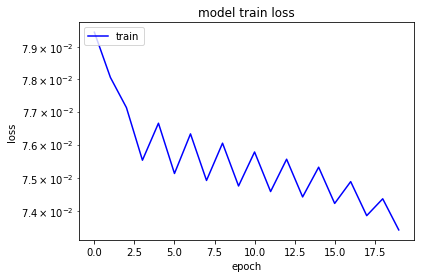

In [25]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.clf()
plt.plot(train_loss_arr, color='blue')
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'train_loss.png')

In [27]:
valid_loss_arr

array([0.07806029, 0.07888003, 0.07552649, 0.07706559, 0.07512809,
       0.0766156 , 0.07491969, 0.07629382, 0.07475504, 0.07601271,
       0.07458933, 0.07575096, 0.07442998, 0.07553601, 0.07423672,
       0.07530849, 0.07387631, 0.07483928, 0.07345744, 0.0743047 ])

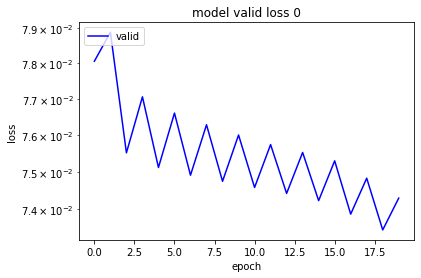

In [28]:
for seq in range(len(X_train)):
    # summarize history for loss
    plt.clf()
    plt.plot(valid_loss_arr, color='blue')
    plt.title('model valid loss ' + str(seq))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['valid'], loc='upper left')
    plt.yscale('log')
    plt.savefig(newpath + '/' + f'valid_loss_{seq}.png')